# Objetivo: Previsão de pacientes na UTI (COVID-19)

Utilizarei a base de dados do Hospital Sírio Libanês. A base de dados esta disponível no site do [Kaggle](https://www.kaggle.com/) na pagina do grupo do Sírio Libanês [COVID-19 - Clinical Data to assess diagnosis](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

Essa base de dados contém informações, não sensíveis, que diz respeito a quantidade de pacientes que foram ou não internados por covid-19 na clínica do hospital durante a pandemia de corona virus. As informações são ricas com respeito ao quadro clínico e a pergunta que vamos tentar responder é: 

> **Dado um novo paciente conseguiremos prever a chance dele ser encaminhado para a UTI?**


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# Importação dos dados e pre processamento

In [2]:
sirio_libanes = pd.read_excel('https://github.com/ConradBitt/BootCamp_DataScience/blob/master/ML%20em%20Saude/dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')
sirio_libanes.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [3]:
def preenche_tabela(dados):
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:,-2:]
    colunas_features_continuas = dados.iloc[:,13:-2].columns
    features_continuas = dados.groupby('PATIENT_VISIT_IDENTIFIER')[colunas_features_continuas].fillna(method='backfill').fillna(method='ffill')
    dados_limpos = pd.concat([features_categoricas, features_continuas, saida], axis=1)
    dados_limpos.columns = dados.columns
    return dados_limpos

In [4]:
dados_limpos = preenche_tabela(sirio_libanes)

Dentre as features dentro do dataframe `x` temos a coluna `AGE_PERCENTIL` que indica se a pessoa faz parte do conglomerado, por exemplo, de até 10 anos.

In [5]:
dados_limpos.AGE_PERCENTIL.unique()

array(['60th', '90th', '10th', '40th', '70th', '20th', '50th', '80th',
       '30th', 'Above 90th'], dtype=object)

Esse dado é quantitativo ordinal, isso porque uma pessoa de até 10 anos é mais nova do que uma pessoa até 40 anos.

O módulo `SKLearn` na classe de preprocessamento tem uma transformação chamada `Labelencoder()`. Esta função basicamente pega as categorias e atribui valores numéricos a cada uma delas. Por exemplo, a função `dados_limpos.AGE_PERCENTIL.unique()` retorna as categorias, logo o método `fit_transform()` de um objeto da classe `LabelEncoder()` ira retornar um array com cada categoria:

In [6]:
from sklearn import preprocessing

In [7]:
pd.get_dummies(dados_limpos.AGE_PERCENTIL.unique())

,10th,20th,30th,40th,50th,60th,70th,80th,90th,Above 90th
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0
5,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1


In [8]:
print(f'Antes:\n{dados_limpos.AGE_PERCENTIL.unique()}')
le = preprocessing.LabelEncoder()
le.fit(dados_limpos.AGE_PERCENTIL)
dados_limpos.AGE_PERCENTIL = le.fit_transform(dados_limpos.AGE_PERCENTIL)
print(f'\nDepois:\n{dados_limpos.AGE_PERCENTIL.unique()}')

Antes:
['60th' '90th' '10th' '40th' '70th' '20th' '50th' '80th' '30th'
 'Above 90th']

Depois:
[5 8 0 3 6 1 4 7 2 9]


Note que o numero atribuido a cada classe não precisa ter necessariamente um peso, pode ser simplesmente um numero aleatório. Mas no caso do `LabelEncoder()` o numero vem da ordenação das strings

O pandas tem um método chamado `astype()` que muda tipo da variável. Neste método pode-se passar um parâmetro `category` assim ele vai ver quais categorias absolutas (por exemplo o retorno do método `.unique()`) e o índice será o valor da categoria. Veja que o retorno do método `unique()` é um array com 10 elementos, então o método `astype('category')` irá retornar 9 categorias de 0 a 9, cada uma atribuida aos 10 elementos:

In [9]:
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype('category').cat.codes

Note que o primeiro elemento tem `60th` e a categoria dele é o $0$, 

In [10]:
dados_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,6-12,0
4,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


Note acima que o resultado da feature `AGE_PERCENTIL` não é mais do tipo $90$th, agora é uma variável categórica.

In [11]:
dados_limpos.query('WINDOW == "0-2" and ICU == 1')

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
5,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
85,17,0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
135,27,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
205,41,1,6,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.666667,-0.858586,-0.689777,-0.399526,-0.891572,-1.000000,-0.663881,-0.858709,0-2,1
235,47,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
240,48,0,5,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
270,54,1,5,0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-0.890980,-0.841512,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
310,62,1,6,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
425,85,1,6,0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.809524,-0.959596,-1.000000,-1.000000,-0.926209,-1.000000,-0.805768,-0.959631,0-2,1
450,90,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1


In [12]:
identificador_dos_pacientes_a_remover = dados_limpos.query('WINDOW == "0-2" and ICU == 1')['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query(f'PATIENT_VISIT_IDENTIFIER not in "{identificador_dos_pacientes_a_remover.tolist}"')

dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000
mean,192.000000,0.467532,4.319481,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,...,-0.758319,-0.811824,-0.910237,-0.817464,-0.758728,-0.848568,-0.771306,-0.812740,-0.910107,0.267532
std,111.168431,0.499074,2.867348,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,...,0.433037,0.296595,0.255396,0.301522,0.389168,0.246814,0.400915,0.295435,0.256035,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,288.000000,1.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.705882,-0.690476,-0.919192,-0.704088,-0.613423,-0.764790,-0.732494,-0.692177,-0.918403,1.000000
max,384.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
def prepare_window(rows):
    # se ao longo da coluna ['ICU'] tiver algum valor:
    if (np.any(rows['ICU'])):
        rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1
    return rows.loc[rows['WINDOW'] == '0-2']

In [14]:
dados_limpos = dados_limpos.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)

dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,5,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0


# Separando dados Treino e Teste

In [15]:
colunas_quantitativas = dados_limpos.columns

sirio_libanes_quantitativos = dados_limpos[colunas_quantitativas].dropna()
sirio_libanes_quantitativos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 384 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 706.1+ KB


Varificar quais colunas ficaram de fora:

In [16]:
for coluna in sirio_libanes.columns:
    if coluna not in colunas_quantitativas:
        print(coluna)

Ou seja, estamos usando todas as features disponíveis. Agora vamos separar as variáveis independentes em `x` e as variáveis dependentes em `y`:

In [17]:
sirio_libanes_quantitativos = sirio_libanes_quantitativos.iloc[:,1:].reset_index().iloc[:,2:]

In [18]:
y = sirio_libanes_quantitativos['ICU']
x = sirio_libanes_quantitativos.drop(['ICU','WINDOW'], axis=1)

# Importando modelos

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Importando métricas

In [20]:
from sklearn.metrics import accuracy_score

# Impotarndo metodo de estatificação

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
%%time
seed = np.random.seed(9834520)

epocas = {}
for epoca in range(0,10):
    # Instanciando modelos
    modelo_dummy = DummyClassifier(strategy='prior')
    modelo_regressao_logistica = LogisticRegression(solver='newton-cg',max_iter=10000)
    modelo_linear_svc = LinearSVC(max_iter=10000)
    modelo_decision_tree = DecisionTreeClassifier()
    
    
    # Separação dos dados
    x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, random_state=seed)

    # Ajuste dos modelos
    modelo_dummy.fit(x_treino,y_treino)
    modelo_regressao_logistica.fit(x_treino,y_treino)
    modelo_linear_svc.fit(x_treino, y_treino)
    modelo_decision_tree.fit(x_treino, y_treino)
    
    # Predição dos modelos
    y_pred_dummy = modelo_dummy.predict(x_teste)
    y_pred_logis = modelo_regressao_logistica.predict(x_teste)
    y_pred_linear_svc = modelo_linear_svc.predict(x_teste)
    y_pred_decision_tree = modelo_decision_tree.predict(x_teste)
    

    # Métricas de qualidade
    acc_dummy = accuracy_score(y_teste, y_pred_dummy)
    acc_logis = accuracy_score(y_teste, y_pred_logis)
    acc_linear_svc = accuracy_score(y_teste, y_pred_linear_svc)
    acc_decision = accuracy_score(y_teste, y_pred_decision_tree)
    
    # Exibindo méétricas
    epocas[epoca] = (acc_dummy, acc_logis, acc_linear_svc, acc_decision)

for chave, valor in epocas.items():
    print(f'Epoca {chave} - '+'\033[34m'+f'Dummy: {valor[0].round(2)*100:.2f}% | Logistic: {valor[1].round(2)*100:.2f}% | Linear SVC: {valor[2].round(2) * 100:.2f} | Decision Tree: {valor[3].round(2) * 100:.2f} '+'\033[0;0m')


epocas = pd.DataFrame(epocas, index=['Dummy','Logistic','LinearSVC', 'DecisionTree']).round(3) * 100
descricao_epocas = epocas.T.describe().T

display(descricao_epocas)

Epoca 0 - Dummy: 47.00% | Logistic: 76.00% | Linear SVC: 75.00 | Decision Tree: 62.00 
Epoca 1 - Dummy: 49.00% | Logistic: 75.00% | Linear SVC: 75.00 | Decision Tree: 60.00 
Epoca 2 - Dummy: 49.00% | Logistic: 69.00% | Linear SVC: 69.00 | Decision Tree: 70.00 
Epoca 3 - Dummy: 41.00% | Logistic: 81.00% | Linear SVC: 78.00 | Decision Tree: 67.00 
Epoca 4 - Dummy: 41.00% | Logistic: 73.00% | Linear SVC: 71.00 | Decision Tree: 68.00 
Epoca 5 - Dummy: 47.00% | Logistic: 75.00% | Linear SVC: 69.00 | Decision Tree: 73.00 
Epoca 6 - Dummy: 50.00% | Logistic: 69.00% | Linear SVC: 69.00 | Decision Tree: 70.00 
Epoca 7 - Dummy: 45.00% | Logistic: 67.00% | Linear SVC: 70.00 | Decision Tree: 61.00 
Epoca 8 - Dummy: 50.00% | Logistic: 67.00% | Linear SVC: 66.00 | Decision Tree: 61.00 
Epoca 9 - Dummy: 47.00% | Logistic: 78.00% | Linear SVC: 78.00 | Decision Tree: 72.00 


,count,mean,std,min,25%,50%,75%,max
Dummy,10.0,46.47,3.495728,40.6,45.325,46.90,49.00,50.0
Logistic,10.0,72.92,4.998400,66.7,68.800,73.95,75.75,81.2
LinearSVC,10.0,71.88,4.349151,65.6,68.800,70.30,75.00,78.1
DecisionTree,10.0,66.47,4.673578,60.4,61.750,67.20,69.80,72.9


CPU times: user 10.7 s, sys: 155 ms, total: 10.9 s
Wall time: 8.31 s


# Matriz de confusão

In [23]:
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt

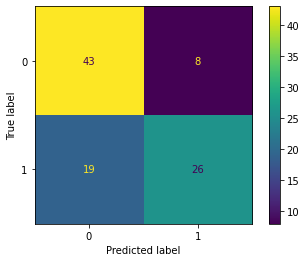

In [24]:
plot_confusion_matrix(modelo_decision_tree, x_teste, y_teste);

Na matriz acima temos os **valores verdadeiros** em função dos **valores preditos**, em uma classificação binária. Por exemplo, se o valor verdadeiro é $1$ e o modelo predice $0$, então soma um no elemento da matriz, se o valor verdadeiro é $0$ e o modelo predice $0$ então soma um no elemento da matriz. Assim temos exatamente quantos foram preditos corretamente na diagonal principal.

A matriz de confusão ajuda a entender melhor o impacto de cada acerto e erro do modelo. Por exemplo 

> Qual o impacto do modelo dizer que **um paciente não precisa** de um leito de UTI **dado que ele precisa?**

> Qual o impacto do modelo dizer que **um paciente precisa** de um leito de UTI **dado que ele precisa?** 

> Qual o impacto do modelo dizer que **um paciente precisa** de um leito de UTI **dado que ele não precisa?** 

> Qual o impacto do modelo dizer que **um paciente não precisa** de um leito de UTI **dado que ele não precisa?** 

No caso do problema do hopital o impacto de não encaminhar um paciente para a UTI dado que ele precisa do serviço é extremamente grave pois o paciente pode retonar para a casa e isso pode agravar a situação ao ponto dele não conseguir voltar ao hospital. A penalidade de perder uma vida tende ao infinito, neste caso.

Na matriz de confusão a acurácia é representada na razão entre a soma dos elementos da diagonal principal pela soma de todos os elementos. Então a ideia no problema do hospital é tentar reduzir o máximo a situação em que o modelo não encaminha um paciente para a UTI dado que ele realmente precisa.

CPU times: user 1.86 s, sys: 36 ms, total: 1.89 s
Wall time: 1.37 s


Text(0.5, 1.0, 'Decision Tree Classifier')

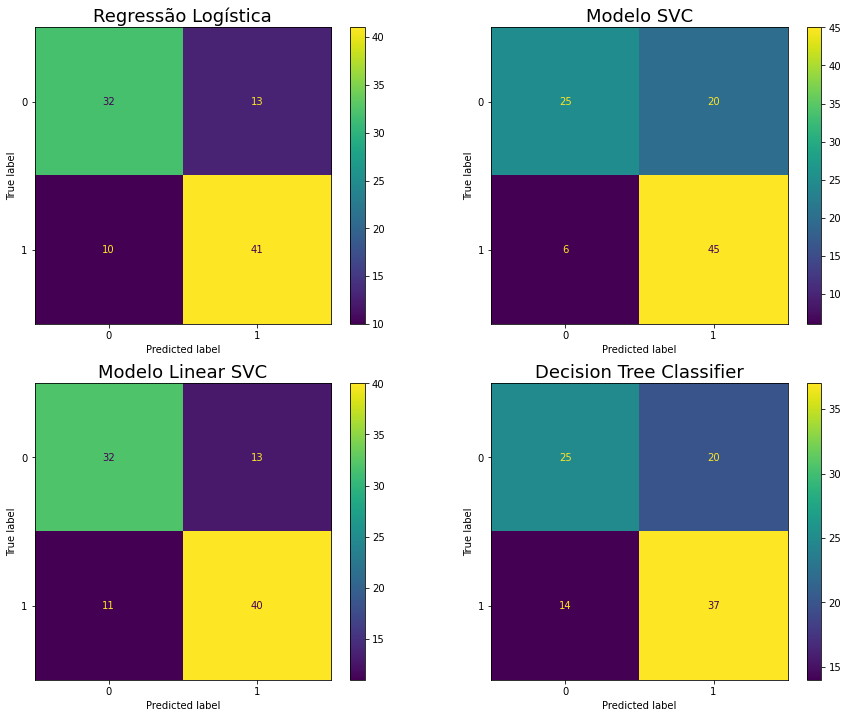

In [25]:
%%time
seed = np.random.seed(9834520)

# Instanciando modelos
modelo_dummy = DummyClassifier(strategy='prior')
modelo_regressao_logistica = LogisticRegression(solver='newton-cg',max_iter=10000)
modelo_svc = SVC(max_iter=10000, kernel='sigmoid')
modelo_linear_svc = LinearSVC(max_iter=10000)
modelo_decision_tree = DecisionTreeClassifier()


# Separação dos dados
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, random_state=seed)

# Ajuste dos modelos
modelo_dummy.fit(x_treino,y_treino)
modelo_regressao_logistica.fit(x_treino,y_treino)
modelo_svc.fit(x_treino, y_treino)
modelo_linear_svc.fit(x_treino, y_treino)
modelo_decision_tree.fit(x_treino, y_treino)

# Predição dos modelos
y_pred_dummy = modelo_dummy.predict(x_teste)
y_pred_logis = modelo_regressao_logistica.predict(x_teste)
y_pred_svc = modelo_svc.predict(x_teste)
y_pred_linear_svc = modelo_linear_svc.predict(x_teste)
y_pred_decision_tree = modelo_decision_tree.predict(x_teste)


f, ax = plt.subplots(2, 2,figsize=(15,12))

plot_confusion_matrix(modelo_regressao_logistica, x_teste, y_teste,
                      ax = ax[0,0]).ax_.set_title('Regressão Logística', fontsize=18)

plot_confusion_matrix(modelo_svc, x_teste, y_teste,
                      ax=ax[0,1]).ax_.set_title('Modelo SVC', fontsize=18)

plot_confusion_matrix(modelo_linear_svc, x_teste, y_teste,
                      ax=ax[1,0]).ax_.set_title('Modelo Linear SVC', fontsize=18);

plot_confusion_matrix(modelo_decision_tree, x_teste, y_teste,
                      ax=ax[1,1]).ax_.set_title('Decision Tree Classifier', fontsize=18);

Note que a matriz de confusão permite uma análise mais criteriosa do que simplesmente a acurácia, podemos analisar a precisão e revocação também. Em outras palavras:

> **A acurácia permite metrificar qual modelo acerta mais, já a matriz de confusão permite metrificar quem erra menos.**  

Considerando a matriz de confusão com a seguinte forma, quando falamos de precisão e revocação existem alguns termpos que precisam ser definidos:

$$\begin{bmatrix}
    a_{00} & a_{01} \\
    a_{10} & a_{11} \\
\end{bmatrix} = 
\begin{bmatrix}
    \color{blue}{VN} & \color{darkorange}{FN} \\
    \color{darkorange}{FP} & \color{blue}{VP} \\
\end{bmatrix}
$$

> **Verdadeiro Negativo** ($\color{blue}{VN}$): Predição correta, dado que o valor verdadeiro é negativo. (elemento $a_{00}$)

> **Verdadeiro Positivo** ($\color{blue}{VP}$): Predição correta, dado que o valor verdadeiro é positivo. (elemento $a_{11}$)

> **Falso positivo** ($\color{darkorange}{FP}$): Predição errada, dado o valor verdadeiro que é positivo. (elemento $a_{10}$)

> **Falso Negativo** ($\color{darkorange}{FN}$): Predição errada, dado o valor verdadeiro que é negativo. (elemento $a_{01}$)

Um jeito bem intuitivo de entender estes conceitos é pensar de forma binária, o primeiro elemento é a linha que representa os valores verdadeiros, o segundo é a coluna que representa os valores preditos, logo o resultado fica da seguinte maneira: `i == j`? Resposta: `True` or `False` => `Valor real seguido da predição`

> `0 == 0`? Reposta: `Verdade` => `Verdadeiro negativo`

> `1 == 1`? Reposta: `Verdade` => `Verdadeiro positivo`

> `0 == 1`? Reposta: `False` => `Falso negativo`

> `1 == 0`? Reposta: `False` => `Falso positivo`


Vamos analisar essas quantidades referentes à matriz de confusão do modelo de regressão logistica:

In [26]:
vp = 41
vn = 32
fp = 13
fn = 10

In [27]:
from sklearn.metrics import classification_report

```python
sklearn.metrics.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')
```

`return`:
> Text summary of the precision, recall, F1 score for each class. Dictionary returned if output_dict is True. 

In [28]:
print(classification_report(y_teste, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.64      0.56      0.60        45
           1       0.65      0.73      0.69        51

    accuracy                           0.65        96
   macro avg       0.65      0.64      0.64        96
weighted avg       0.65      0.65      0.64        96



Passando o hiperparâmetro `output_dict=True` podemos fornecer a estrutura a um dataframe.

In [29]:
pd.DataFrame(classification_report(y_teste, y_pred_decision_tree,output_dict=True)).T

,precision,recall,f1-score,support
0,0.641026,0.555556,0.595238,45.000000
1,0.649123,0.725490,0.685185,51.000000
accuracy,0.645833,0.645833,0.645833,0.645833
macro avg,0.645074,0.640523,0.640212,96.000000
weighted avg,0.645327,0.645833,0.643022,96.000000


## Classification Report

Na documentação da função `sklearn.metrics.precision_recall_fscore_support`, temos a descrição do que é `precision`, `recall` e o `f1_score`:

> The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

> The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

> The `F-beta score` can be interpreted as **a weighted harmonic mean of the precision and recall**, where an `F-beta score` reaches its best value at 1 and worst score at 0.

> The `F-beta score` weights recall more than precision by a factor of beta. `beta == 1.0` means recall and precision are equally important.

> The support is the number of occurrences of each class in `y_true`.

Temos então que a acurácia é um indicador de acerto do modelo, sejá este acerto um verdadeiro positivo ou um verdadeiro negativo. Já a **precisão, como já foi dito acima, é um indicador da capacidade do modelo acertar, ou seja, de não rotular um como positivo algo que é negativo**.

Por outro lado, o recall, também conhecido como revocação é basicamente o simétrico da precisão. **Recall é um indicador da capacidade do modelo não rotular como falso algo que é positivo**. A imagem a seguir pode ajudar a ilustrar o significado de cada métrica

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/320px-Precisionrecall.svg.png' width=40%>

Outra métrica indicada no `precision_recall_fscore_support` é o `F-beta Score`. Este indicador é uma média harmônica ponderada da precisão e da revocação. F-beta varia de 0 até 1, sendo o valor máximo um indicador de que a precisão e a revocação são igualmente importantes. O cálculo do $f_\beta$ é realizado da seguinte maneira:

$$ f_\beta = \frac{2 (p \times r)}{ p + r}.$$

Uma característica de uma média harmônica é representar duas quantidade de acordo com uma única medida, logo se a média harmônica da precisão $p$ e do recall $r$ esta baixa (próxima de $0$), siginifca que uma das duas quantidade esta baixa. Ao passo que se as duas estão altas o valor é alto, veja um exemplo:


In [30]:
def f_beta(p, r):
    return (2*(p*r)) / (p + r)


p1,p2,p3 = 0.5, 0.9, 1.0
r1,r2,r3 = 0.5, 0.5, 0.3

print('f_beta(p,r) = média harmonica ponderada')
print(f'f_beta({p1},{r1}) = {f_beta(p1,r1):.2f}')
print(f'f_beta({p2},{r2}) = {f_beta(p2,r2):.2f}')
print(f'f_beta({p3},{r3}) = {f_beta(p3,r3):.2f}')

f_beta(p,r) = média harmonica ponderada
f_beta(0.5,0.5) = 0.50
f_beta(0.9,0.5) = 0.64
f_beta(1.0,0.3) = 0.46


> Note que se $p$ e $r$ são próximos, então $f_\beta$ é próximo, entretanto se um valor é alto e o outro é baixo, a tendência do $f_\beta$ é ir em direção ao valor mais baixo.

Além disso existem outras implementações da propria métrica F-Score, alguns métodos conseguem dar um peso maior para a precisão ou para o recall.



### Utilidade das métricas

A precisão e revocação fornecem uma informação muito mais refinada a respeito de um modelo e são de suma importancia dependendo do problema que a equipe busca selecionar. Por exemplo, gestores de seguros, quando fazem uma análise de risco com respeito de um cliente podem levar em conta geralmente a precisão das estimativas, entretanto pro mercado de seguros em si não é tão relevante o quanto a empresa acerta, mas sim o quanto ela erra.

Corretora de valores imobiliarios também, gerentes de fundos podem estar muito mais interessados na revocação de um modelo que preve investimentos a longo prazo mais do que nos ganhos em si, porque o objetivo não é só ganhar dinheiro, mas evitar de perder. 

Em geral todos os problemas cuja análise do resultado pode ser condensada na frase

> **Errar pouco em algumas situações é melhor do que acertar muito**,

utiliza-se a revocação (*recall*). No objetivo deste trabalho por exemplo, a importancia de não se deparar com um falso negativo é extremamente relevante e pode ajudar a salvar vidas, pois estimar que um paciente não precisa de UTI dado que ele precisa pode leva-lo a óbito.

## Exibindo arvore de decisão

Um dos modelo utilizados é o `DecisionTreeClassifier`, que é basicamente uma árvore de seleção binária que classifica os elementos de acordo com algum índice, por exemplo o indice de Gini. Esse classificar é um dos poucos que pode ser uma etapa interessante analisar os criérios de seleção do modelo.

Para visualizar a árvore de decisão vamos utilizar um módulo do python chamado [**GraphViz**](https://graphviz.org/). Com ele é possível visualizar a árvore de decisão do modelo, isso porque o `SKlearn` tem uma forma de exportar o modelo para uma visualização do GraphViz

In [31]:
import graphviz
from sklearn.tree import export_graphviz

É importante salientar que o modelo do Sirio Libanes fornece mais de 200 features, portanto é inviável visualizar todas. Dito isso, vou selecionar apenas as features no quesito `DISEASE GROUPING`:

In [32]:
dot_data = export_graphviz(modelo_decision_tree, out_file=None,
                           filled = True, rounded = True,
                           feature_names = x.columns,
                           class_names=['Não Precisa de UTI', 'Precisa de UTI '],rotate=True)

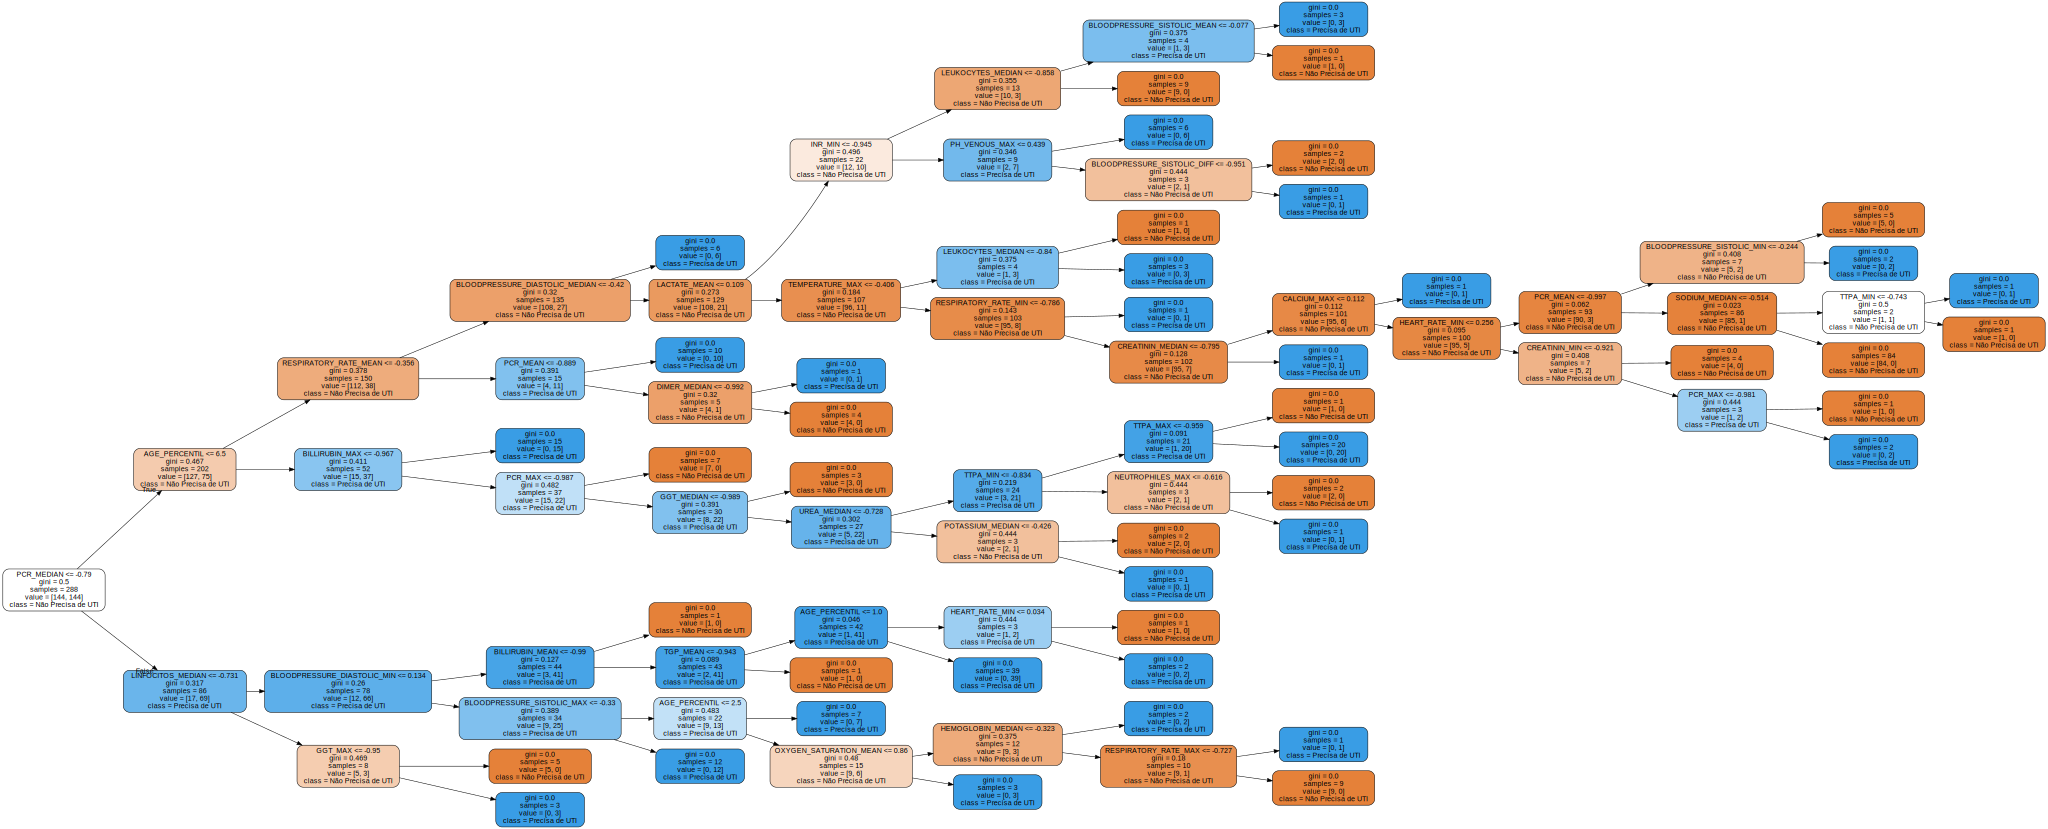

In [33]:
grafico = graphviz.Source(dot_data)
grafico

Esta árvore é extremamente grande e pode ser um tanto complexo interpreta-la. O módulo `pydotplus` permite manipular o tamanho da árvore do graphviz:

In [34]:
#import pydotplus
#pydot_graph = pydotplus.graph_from_dot_data(dot_data)
#pydot_graph.write_png('Tamanho_Original.png')
#pydot_graph.set_size('"5,5!"')
#pydot_graph.write_png('resized_tree.png')

# Curva AUC e ROC

Anteriormente dentre os modelos instanciados, treinados e testados foi possível entender a qualidade de um modelo perante os indicadores precision e recall. Temos a precisão que é a capacidade de classificar positivamente dado que eles são positivos e temos também a revocação (recall) que é dentre todas as classe positivas quais conseguimos classificar corretamente.

Aparentemente o modelo que tem a menor revocação é o Linear SVC, veja:

Text(0.5, 1.0, 'Modelo Linear SVC')

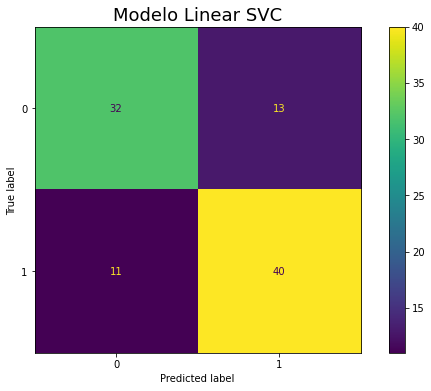

In [35]:
fig = plot_confusion_matrix(modelo_linear_svc, x_teste, y_teste)
fig.figure_.set_size_inches(10,6)
fig.ax_.set_title('Modelo Linear SVC', fontsize=18)


A quantidade de falso positivo é de 3, ou seja, apenas 3 dos mais de 200 pacientes foram classificados como "não precisam de UTI" dado que ele precisam. Por outro lado ocorre um problema grave se levar em conta o objetivo do nosso projeto. Veja a quantidade de falso negativos, são ao todo 36 $FN$. Essa quantidade representa todos os pacientes que não precisavam de UTI mas foram enviados mesmo assim.

Se levarmos em conta que o objetivo do projeto é encontrar um modelo que consiga prever se um paciente precisa ou não de uma UTI a fim de reduzir a super lotação dos hospitais, então nosso modelo é péssimo,**pois para minimizar o recall ele simplesmente mandou todo mundo pra UTI**. Ou seja, a metrica que estamos utilizando precisa levar em conta tanto a precisão quanto a revocação.

## AUC (Area under curve)

A área sob uma curva é um valor escalar que mede o desempenho geral de um classificador binário ([Hanley e McNeil 1982](https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_209#CR02091)). O valor de AUC está dentro do intervalo $[0,5-1,0]$, onde o valor mínimo representa o desempenho de um classificador aleatório e o valor máximo corresponderia a um classificador perfeito (por exemplo, com uma taxa de erro de classificação equivalente a zero). 

O AUC é uma medida geral bem robusta para avaliar o desempenho dos classificadores de pontuação porque seu cálculo se baseia na curva ROC completa e, portanto, envolve todos os limites de classificação possíveis. A AUC é normalmente calculada adicionando áreas trapezoidais sucessivas abaixo da curva ROC. A abaixo mostra as curvas ROC para dois classificadores de pontuação A e B. Neste exemplo, o classificador A tem um valor de AUC maior do que o classificador B, justamente porque a curva se aproxima do eixo *True Positive Rate* logo ela  tem uma sensibilidade maior das quantidades de falsos positivos e falsos negativos:

<img src='https://media.springernature.com/lw785/springer-static/image/prt%3A978-1-4419-9863-7%2F1/MediaObjects/978-1-4419-9863-7_1_Part_Fig1-209_HTML.gif'>

> fonte: https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_209

O módulo `SKlearn` tem uma função que executa uma rotina para o cálculo a curva ROC e consequentemente o cálculo da área AUC:

```python
sklearn.metrics.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)
```

> Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

> **Note**: this implementation can be used with binary, multiclass and multilabel classification, but some restrictions apply (see Parameters).

É importante salientar que para a comparação precisamos fornecer os valores verdadeiros `y_teste` mas para a comparação precisamos fornecer o `y_score`:

`y_score` array-like of shape (n_samples,) or (n_samples, n_classes)
    
**Target scores**

> In the binary case, it corresponds to an array of shape (n_samples,). Both probability estimates and non-thresholded decision values can be provided. The probability estimates correspond to the probability of the class with the greater label, i.e. estimator.classes_[1] and thus `estimator.predict_proba(X, y)[:, 1]`. The decision values corresponds to the output of `estimator.decision_function(X, y)`.

> In the multiclass case, it corresponds to an array of shape (n_samples, n_classes) of probability estimates provided by the `predict_proba` method. The probability estimates must sum to 1 across the possible classes. In addition, the order of the class scores must correspond to the order of labels, if provided, or else to the numerical or lexicographical order of the labels in `y_true`. See more information in the User guide;

> In the multilabel case, it corresponds to an array of shape (n_samples, n_classes). Probability estimates are provided by the `predict_proba` method and the non-thresholded decision values by the decision_function method. The probability estimates correspond to the probability of the class with the greater label for each output of the classifier. See more information in the User guide.

Ou seja, o `y_score` é basicamente retornar os resultados como uma matriz de probabilidades, onde cada coluna representa as possíveis classes e os elementos das linhas do vetor representam a probabilidade de cada classificação

In [36]:
from sklearn.metrics import roc_auc_score

In [37]:
y_pred_prob_arvore = modelo_decision_tree.predict_proba(x_teste)
y_pred_prob_arvore[:3,:3]

array([[0., 1.],
       [0., 1.],
       [1., 0.]])

Note que na coluna 0 temos as probabilidades de serem classificadas para essa coluna, já na coluna 1 temos a probabilidade de cada elemento ser classificado para esta coluna.

In [38]:
roc_auc_score(y_teste,y_pred_prob_arvore[:,1])

0.6405228758169935

#### Definindo uma função para rodar os modelos

In [39]:
def run_models(modelo, x, y, random_state = None):
    nome_modelo = str(str(mod)[:-2])
    
    seed = np.random.seed(random_state)
    
    # Instanciando modelos
    modelo_dummy = DummyClassifier(strategy='prior', random_state=seed)

    # Separação dos dados
    x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify=y, random_state=seed)

    # Ajuste dos modelos
    modelo_dummy.fit(x_treino,y_treino)
    modelo.fit(x_treino, y_treino)
    
    # predições 
    y_pred_dummy = modelo_dummy.predict(x_teste)
    y_pred = modelo.predict(x_teste)
    
    # predicoes probabilisticas
    y_pred_prob_dummy = modelo_dummy.predict_proba(x_teste)
    y_pred_prob = modelo.predict_proba(x_teste)
    
    # metricas de qualidade
    acc_dummy = accuracy_score(y_teste, y_pred_dummy)
    acc = accuracy_score(y_teste, y_pred)
    
    auc_dummy = roc_auc_score(y_teste, y_pred_prob_dummy[:,1])
    auc = roc_auc_score(y_teste, y_pred_prob[:,1])
    
    qualidade_preditiva = acc - acc_dummy
    qualidade_auc = auc - auc_dummy
    
    print(f'Acurácia - \t {nome_modelo}: {acc * 100: .2f}% \t | \t Dummy: {acc_dummy *100 :.2f}%')
    print(f'AUC \t - \t {nome_modelo}: {auc * 100: .2f}% \t | \t Dummy: {auc_dummy *100 :.2f}%\n')
    
    print(f'Qualidade preditiva: \t{nome_modelo} Vs Dummy: {qualidade_preditiva * 100 :.2f}% ')
    print(f'Qualidade AUC: \t\t{nome_modelo} Vs Dummy: {qualidade_auc * 100 :.2f}% ')
    
    print("\nClassification Report:\n", classification_report(y_teste, y_pred))
    

In [40]:
mod = DecisionTreeClassifier()

In [41]:
run_models(mod,x,y, random_state = 87234512)

Acurácia - 	 DecisionTreeClassifier:  65.62% 	 | 	 Dummy: 51.04%
AUC 	 - 	 DecisionTreeClassifier:  65.50% 	 | 	 Dummy: 50.00%

Qualidade preditiva: 	DecisionTreeClassifier Vs Dummy: 14.58% 
Qualidade AUC: 		DecisionTreeClassifier Vs Dummy: 15.50% 

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.60      0.63        47
           1       0.65      0.71      0.68        49

    accuracy                           0.66        96
   macro avg       0.66      0.66      0.65        96
weighted avg       0.66      0.66      0.65        96



In [42]:
def run_dummy_logistic_DecisionTree(x, y, epochs=10, random_state = None, verbose=False):

    seed = np.random.seed(random_state)

    epocas = {}
    for epoca in range(0,epochs):
        # Instanciando modelos
        modelo_dummy = DummyClassifier(strategy='prior')
        modelo_regressao_logistica = LogisticRegression(solver='newton-cg',max_iter=10000)
        modelo_decision_tree = DecisionTreeClassifier()


        # Separação dos dados
        x_treino, x_teste, y_treino, y_teste = train_test_split(x,y,stratify=y)

        # Ajuste dos modelos
        modelo_dummy.fit(x_treino,y_treino)
        modelo_regressao_logistica.fit(x_treino,y_treino)
        modelo_decision_tree.fit(x_treino, y_treino)

        # Predição dos modelos
        y_pred_dummy = modelo_dummy.predict_proba(x_teste)
        y_pred_logis = modelo_regressao_logistica.predict_proba(x_teste)
        y_pred_decision_tree = modelo_decision_tree.predict_proba(x_teste)


        # Métricas de qualidade
        auc_dummy = roc_auc_score(y_teste, y_pred_dummy[:,1])
        auc_logis = roc_auc_score(y_teste, y_pred_logis[:,1])
        auc_decision = roc_auc_score(y_teste, y_pred_decision_tree[:,1])

        # Exibindo méétricas
        epocas[epoca] = (auc_dummy, auc_logis, auc_decision)
    
    if verbose:
        for chave, valor in epocas.items():
            print(f'Epoca {chave}-\t '+'\033[34m'+f'Dummy: {valor[0].round(2)*100:.2f}%\t| Logistic: {valor[1].round(2)*100:.2f}%\t | Decision Tree: {valor[2].round(2) * 100:.2f} '+'\033[0;0m')


    epocas = pd.DataFrame(epocas, index=['Dummy','Logistic', 'DecisionTree'])
    descricao_epocas = epocas.T.describe().T
    
    conf_int = pd.concat([descricao_epocas['mean'] - 2 * descricao_epocas['std'],
                         descricao_epocas['mean'] + 2 * descricao_epocas['std']],
                         axis=1, ignore_index=False)
    conf_int.columns = ['min_conf_int', 'max_conf_int']
    
    descricao_epocas = pd.concat([descricao_epocas, conf_int], axis=1, ignore_index=False)
    
    return descricao_epocas


In [43]:
run_dummy_logistic_DecisionTree(x,y,epochs=20, random_state=98741239)

,count,mean,std,min,25%,50%,75%,max,min_conf_int,max_conf_int
Dummy,20.0,0.500000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Logistic,20.0,0.804234,0.047742,0.711246,0.766826,0.808076,0.837495,0.903604,0.708749,0.899718
DecisionTree,20.0,0.638330,0.041509,0.553843,0.613168,0.640360,0.668747,0.709075,0.555311,0.721349


In [44]:
def run_models(modelo, x, y, epochs=31, random_state = None):
    
    nome_modelo = str(str(mod)[:-2])
    
    epocas = {}
    
    seed = np.random.seed(random_state)
    
    for epoca in range(0, epochs):
        # Instanciando modelos
        modelo_dummy = DummyClassifier(strategy='most_frequent', random_state=seed)

        # Separação dos dados
        x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify=y, random_state=seed)

        # Ajuste dos modelos
        modelo_dummy.fit(x_treino,y_treino)
        modelo.fit(x_treino, y_treino)

        # predições 
        y_pred_dummy = modelo_dummy.predict(x_teste)
        y_pred = modelo.predict(x_teste)

        # predicoes probabilisticas
        y_pred_prob_dummy = modelo_dummy.predict_proba(x_teste)
        y_pred_prob = modelo.predict_proba(x_teste)

        # metricas de qualidade
        acc_dummy = accuracy_score(y_teste, y_pred_dummy)
        acc = accuracy_score(y_teste, y_pred)

        auc_dummy = roc_auc_score(y_teste, y_pred_prob_dummy[:,1])
        auc = roc_auc_score(y_teste, y_pred_prob[:,1])
        
        # adicionando à epoca
        epocas[epoca] = (acc_dummy, auc_dummy, acc, auc)
    dataframe_resultados = pd.DataFrame(epocas, index = ['acc_dummy', 'auc_dummy', f'acc_{nome_modelo}', f'auc_{nome_modelo}']).T
    return dataframe_resultados

In [45]:
run_models(mod, x, y, 30).describe().round(4)

,acc_dummy,auc_dummy,acc_DecisionTreeClassifier,auc_DecisionTreeClassifier
count,30.0000,30.0,30.0000,30.0000
mean,0.5104,0.5,0.6319,0.6323
std,0.0000,0.0,0.0483,0.0484
min,0.5104,0.5,0.5417,0.5397
25%,0.5104,0.5,0.5964,0.5971
50%,0.5104,0.5,0.6250,0.6246
75%,0.5104,0.5,0.6641,0.6652
max,0.5104,0.5,0.7500,0.7495


In [46]:
from sklearn.metrics import plot_roc_curve

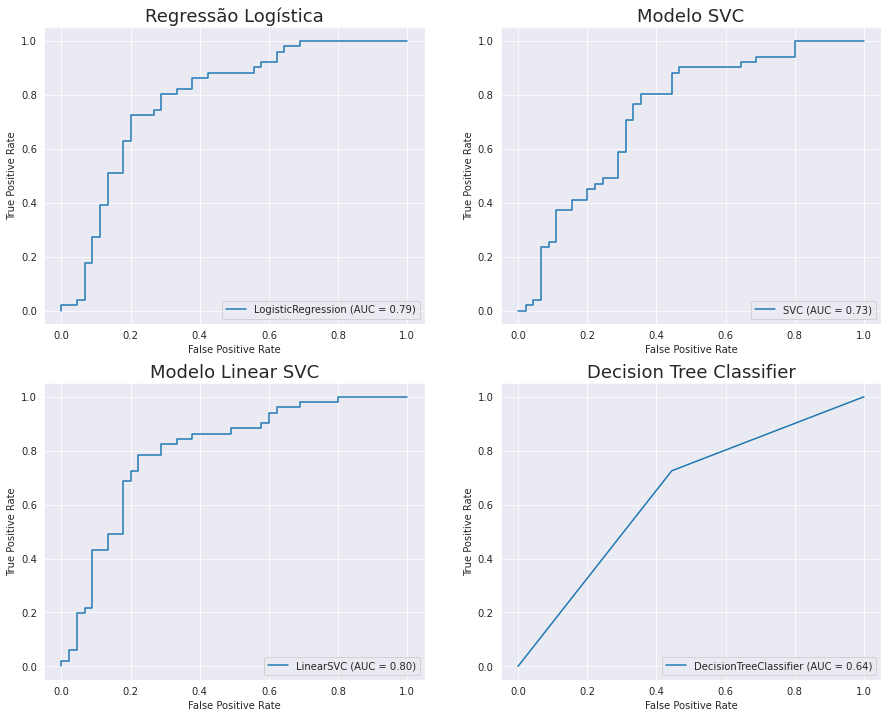

In [47]:
sns.set_style('darkgrid')
f, ax = plt.subplots(2, 2,figsize=(15,12))

plot_roc_curve(modelo_regressao_logistica, x_teste, y_teste,
               ax = ax[0,0]).ax_.set_title('Regressão Logística', fontsize=18)

plot_roc_curve(modelo_svc, x_teste, y_teste,
               ax=ax[0,1]).ax_.set_title('Modelo SVC', fontsize=18)

plot_roc_curve(modelo_linear_svc, x_teste, y_teste,
               ax=ax[1,0]).ax_.set_title('Modelo Linear SVC', fontsize=18);

plot_roc_curve(modelo_decision_tree, x_teste, y_teste,
               ax=ax[1,1]).ax_.set_title('Decision Tree Classifier', fontsize=18);

> Podemos verificar atravpes da curva AUC que o método que tem o melhor balanceamento entre a precisão e o recall é o método `LogisticRegression`

# Efeitos de Aleatóriedade

Até aqui utilizamos alguns modelos, como por exemplo o Logistic Regression, Decision Tree Classifier, Linear SVC etc. Muitos outros podem ser utilizados, acontece que dependendo dos dados de treino e teste que são selecionados, as métricas de qualidade de um modelo podem mudar, simplesmente pela aleatóriedade na seleção dos conjuntos.

Tendo em vista que a cada epoca, separar os dados, treinar e testar um modelo, as métricas provem de seleções aleatórias e portanto os resultados também contém uma aleatoriedade. Então visando fornecer resultados mais bem comportado, podemos estrair a media de varias épocas. Em muitos casos é melhor até fornecer o intervalo de confiança das métricas de qualidade do modelo (Acurácia, precisão, recall, F1, AUC).

Entretanto, mesmo ao realizar várias épocas, podemos dar o "azar" de não selecionar um conjunto específico de dados por mera chance. Logo um jeito de contornar este problema é utilizar uma tecnica conhecida como "*cross validation*" ou *validação cruzada*. Nesta tenica basicamente a cada epoca os grupos de treino e teste serão bem definidos a fim de passar por todo o conjunto de dados.

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/1280px-K-fold_cross_validation_EN.svg.png' width=70%>

Ou seja, em outras palavras o cross validation é uma forma de garantir que todos os dados sejam vistos, ao passo que o `train_test_split()` em iterado em várias épocas, que foi implementado é uma forma não tão garantida de que todos os dados sejam utilizados no treino.

Para usar a técnica de validação cruzada basta importar a função no SciKitLearning:

```python
sklearn.model_selection.cross_validate(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False, return_estimator=False, error_score=nan)
```

basta fornecer um estimador(algum modelo instanciado), as features(`x`) e os classificadores(`y`) e o mais importante a quantidade de grupos em que os dados de treino e teste serão estratificados.

`cv` int, cross-validation generator or an iterable, `default=None`

   Determines the cross-validation splitting strategy. Possible inputs for cv are:
   
* None, to use the default 5-fold cross validation,

* int, to specify the number of folds in a (Stratified)KFold,

* CV splitter,

* An iterable yielding (train, test) splits as arrays of indices.
  
  For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.

    Refer User Guide for the various cross-validation strategies that can be used here.

    Changed in version 0.22: cv default value if None changed from 3-fold to 5-fold.



In [48]:
from sklearn.model_selection import cross_validate

Podemos considerar o teorema do limite central por exemplo e levar em conta que a distribuição das médias amostrais tende a uma distribuição normal, se o numero de amostras for maior que 30, logo se fatiarmos os dados em 35 por exemplo, talvez o resultado seja uma boa estimativa para a qualidade do modelo. Entretando, no [User Guide](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) do cross validate, existe a citação de alguns artigos cientificos que indicam um número de grupos entre 3 à 10, acima disso o custo computacional pode ser maior do que a eficiencia do modelo.

> [Ojala and Garriga. Permutation Tests for Studying Classifier Performance. J. Mach. Learn. Res. 2010](https://www.jmlr.org/papers/volume11/ojala10a/ojala10a.pdf)


In [49]:
pd.DataFrame(cross_validate(modelo_regressao_logistica, x, y=y, cv=10)).T

,0,1,2,3,4,5,6,7,8,9
fit_time,0.051673,0.048469,0.049958,0.048191,0.045891,0.054402,0.056069,0.057027,0.045619,0.047354
score_time,0.004549,0.004492,0.004698,0.004527,0.004489,0.007148,0.004508,0.004640,0.004591,0.004693
test_score,0.717949,0.769231,0.717949,0.743590,0.815789,0.789474,0.710526,0.736842,0.736842,0.736842


O retorno é um dicionário python então transformei em um data frame para que fique mais fácil visualizar a transposição do dicionario e assim o resultado da separação dos dados, treino e teste são expresso em cada coluna do dataframe acima.

Tratar o resultado como um dataframe permite utilizar várias funções de estatistica descritiva em cima dos resultados do cross validation, veja:

In [50]:
resultado_cross_validate_logistic = pd.DataFrame(cross_validate(modelo_regressao_logistica, x, y=y, cv=10, scoring='roc_auc'))
resultado_cross_validate_logistic.describe().T

,count,mean,std,min,25%,50%,75%,max
fit_time,10.0,0.057513,0.015649,0.044991,0.048706,0.052819,0.054133,0.093433
score_time,10.0,0.006268,0.001796,0.005602,0.005626,0.005683,0.005729,0.011370
test_score,10.0,0.795489,0.022322,0.757895,0.775693,0.805609,0.812084,0.822715


Desta forma é muito mais fácil como se comporta a distribuição das métricas do estimador.

É importante dizer que mesmo o Cross Validation não resolve todos os problemas relacionados a "amostragem", o fato do *slice* ser feito de forma sequencial, pode ser prejudicial se, por exemplo, os dados forem adicionados na base de dados dessa forma.

Então a ideia é antes de usar o cross validation é embaralhar os dados de alguma maneira. O parâmetro `cv` assim como aceita numeros inteiros também aceita uma estrutura do tipo [CV splitter](https://scikit-learn.org/stable/glossary.html#term-CV-splitter). Esta estrutura fornece formas de estratificações para efetuar o cross validation, existem várias [Splitter Classes](https://scikit-learn.org/stable/modules/classes.html#splitter-classes) disponíveis no SKLearn.

O `StratifiedKFold` faz basicamente uma estratificação da base de dados, separando em dados de treino, teste $K$ vezes e depois verificar a validação do modelo. Lembrando que a estratificação é sequencial, portanto se o dataset foi construido levando em conta alguma regra ela pode interferir na qualidade do modelo, para isso existe 

In [51]:
from sklearn.model_selection import StratifiedKFold

tecnica_de_cross_validation_SKFold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=27892345)

resultado_cross_validate_logistic = pd.DataFrame(cross_validate(modelo_regressao_logistica, x, y=y,
                                                                cv=tecnica_de_cross_validation_SKFold,
                                                                scoring='roc_auc'))
resultado_cross_validate_logistic.describe().T

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.069993,0.012393,0.055900,0.062417,0.067162,0.077237,0.087251
score_time,5.0,0.007744,0.001900,0.005711,0.005924,0.008230,0.008686,0.010167
test_score,5.0,0.805537,0.052465,0.748313,0.776653,0.795565,0.820513,0.886640


Para a função `StratifiedKFold()` são passados o numeros de estratificações que serão feitas nos dados e o parâmetro `shuffle` realiza o embaralhamento que pode amezinar problemas na incrementação dos dados no dataset. Note que a métrica de teste **AUC** medio esta em 0.8, muito melhor do que os outros modelos que a gente já testou.

Outra técnica de cross validation que vamos utilizar é a `RepeatedStratifiedKFold`. Nesta técnica ele repete a estratificação selecionando outro dado de validação:

In [52]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [53]:
tecnica_cross_valitadion_RSKFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=278912345)

In [54]:
resultado_cross_validate_logistic = pd.DataFrame(cross_validate(modelo_regressao_logistica, x, y=y,
                                                                cv=tecnica_cross_valitadion_RSKFold,
                                                                scoring='roc_auc'))
resultado_cross_validate_logistic.describe().T

,count,mean,std,min,25%,50%,75%,max
fit_time,50.0,0.049757,0.007483,0.037192,0.044230,0.049110,0.052759,0.078296
score_time,50.0,0.005938,0.000581,0.005606,0.005671,0.005724,0.005896,0.008423
test_score,50.0,0.801002,0.039586,0.690958,0.782557,0.803644,0.823805,0.870445


## Função que roda modelos

desta forma podemos instanciar uma função que roda modelos e utiliza uma técnica de validação cruzada na validação dos resultados:

In [55]:
def run_model_with_cross_validation(model, x, y, n_splits=5, n_repeats=10,
                                    scoring = 'accuracy'):
    
    result_cross_validate = cross_validate(model, x, y = y,
                                           cv = tecnica_cross_valitadion_RSKFold,
                                           scoring = scoring)
    
    estatisticas_descritivas_model_cv = pd.DataFrame(result_cross_validate).describe().T
    
    conf_int_min = estatisticas_descritivas_model_cv['mean'] - 2 *  estatisticas_descritivas_model_cv['std']
    conf_int_max = estatisticas_descritivas_model_cv['mean'] + 2 *  estatisticas_descritivas_model_cv['std']
    conf_int = []

    
    for i in range(0, estatisticas_descritivas_model_cv.shape[0]):
        conf_int.append((conf_int_min.iloc[i].round(7), conf_int_max.iloc[i].round(7)))
    
    
    estatisticas_descritivas_model_cv['conf_int_0.95'] = conf_int
    
    return estatisticas_descritivas_model_cv
    
    

In [56]:
resultado_dummy = run_model_with_cross_validation(modelo_dummy, x, y, scoring='roc_auc')
resultado_dummy

,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
fit_time,50.0,0.001755,0.000741,0.001215,0.001344,0.001505,0.001827,0.005722,"(0.0002727, 0.003237)"
score_time,50.0,0.001835,0.000919,0.001352,0.001418,0.001629,0.001817,0.007581,"(-3.8e-06, 0.0036736)"
test_score,50.0,0.500000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,"(0.5, 0.5)"


In [57]:
resultado_logistic_reg = run_model_with_cross_validation(modelo_regressao_logistica, x, y, scoring='roc_auc')
resultado_logistic_reg

,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
fit_time,50.0,0.050350,0.008849,0.037650,0.044843,0.048744,0.052851,0.088614,"(0.0326513, 0.0680486)"
score_time,50.0,0.006135,0.000983,0.005625,0.005689,0.005757,0.005989,0.010827,"(0.0041683, 0.008101)"
test_score,50.0,0.801002,0.039586,0.690958,0.782557,0.803644,0.823805,0.870445,"(0.7218296, 0.8801743)"


In [58]:
resultado_svc = run_model_with_cross_validation(modelo_svc, x, y, scoring='roc_auc')
resultado_svc 

,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
fit_time,50.0,0.030000,0.002884,0.028100,0.028562,0.029083,0.029685,0.042982,"(0.0242311, 0.0357687)"
score_time,50.0,0.011502,0.001606,0.010573,0.010900,0.011014,0.011360,0.018498,"(0.0082897, 0.0147135)"
test_score,50.0,0.754143,0.045706,0.607069,0.728914,0.754723,0.776466,0.871120,"(0.6627313, 0.8455541)"


In [59]:
resultado_decision_tree = run_model_with_cross_validation(modelo_decision_tree, x, y, scoring='roc_auc')
resultado_decision_tree

,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
fit_time,50.0,0.021291,0.002581,0.017817,0.019545,0.020577,0.022092,0.030091,"(0.0161289, 0.0264523)"
score_time,50.0,0.005608,0.000905,0.005045,0.005193,0.005278,0.005564,0.009516,"(0.0037979, 0.0074173)"
test_score,50.0,0.641612,0.056193,0.520580,0.601468,0.641058,0.674465,0.777200,"(0.5292262, 0.7539974)"


### Os resultados dos modelos:

In [60]:
resultados_modelos = pd.DataFrame({})
resultados_modelos['dummy'] = resultado_dummy.loc['test_score']
resultados_modelos['logistic_reg'] = resultado_logistic_reg.loc['test_score']
resultados_modelos['svc'] = resultado_svc.loc['test_score']
resultados_modelos['decision_tree'] = resultado_decision_tree.loc['test_score']

resultados_modelos.T

,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
dummy,50.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,"(0.5, 0.5)"
logistic_reg,50.0,0.801002,0.039586,0.690958,0.782557,0.803644,0.823805,0.870445,"(0.7218296, 0.8801743)"
svc,50.0,0.754143,0.045706,0.607069,0.728914,0.754723,0.776466,0.87112,"(0.6627313, 0.8455541)"
decision_tree,50.0,0.641612,0.056193,0.52058,0.601468,0.641058,0.674465,0.7772,"(0.5292262, 0.7539974)"


Como já foi dito anteriormente o modelo dummy é um base line a ser superado, pois ele representa um chute aleatório ou o mais provável. Além de comparar as médias e os desvios padrões amostrais, podemos analisar o intervalo de confiança de cada modelo.

## Modificando hiperparâmetros da árvore

A árvore de decisão é um dos modelos muito bem implementados que contém vários parâmetros que podem ser alterados a fim de melhorar a qualidade do modelo. Por exemplo, podemos mudar o critério de separação `gini` para `entropy`, podemos mudar a "profundidade da árvore" com o `max_depth`

In [61]:
modelo_decision_tree_2 = DecisionTreeClassifier(max_depth=2, random_state=358734)
modelo_decision_tree_4 = DecisionTreeClassifier(max_depth=4, random_state=358734)
modelo_decision_tree_6 = DecisionTreeClassifier(max_depth=6, random_state=358734)

resultado_decision_tree = run_model_with_cross_validation(modelo_decision_tree_2, x, y, scoring='accuracy').loc[['test_score']]
display(resultado_decision_tree)

resultado_decision_tree = run_model_with_cross_validation(modelo_decision_tree_4, x, y, scoring='accuracy').loc[['test_score']]
display(resultado_decision_tree)

resultado_decision_tree = run_model_with_cross_validation(modelo_decision_tree_6, x, y, scoring='accuracy').loc[['test_score']]
display(resultado_decision_tree)

,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
test_score,50.0,0.658096,0.059111,0.545455,0.613636,0.662338,0.701299,0.779221,"(0.5398752, 0.7763175)"


,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
test_score,50.0,0.675014,0.064804,0.532468,0.636364,0.675325,0.724026,0.805195,"(0.5454052, 0.8046222)"


,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
test_score,50.0,0.664388,0.061102,0.558442,0.623377,0.675325,0.710526,0.802632,"(0.5421844, 0.7865921)"


> Note que dependendo da profundidade da árvore de decisão nosso modelo acerta mais ou menos. Por que isso acontece? 

Bom, para resolver esta pergunta precisamos exibir não só as métricas de qualidade dos dados de `treino` mas também as métricas referênte aos dados de `teste`. Para isso vou modificar um pouco a função `run_model_with_cross_validation()`:

In [62]:
def run_model_with_cross_validation(model, x, y, n_splits=5, n_repeats=10, scoring = 'accuracy', random_state=None):
    
    tecnica_cross_valitadion_RSKFold = RepeatedStratifiedKFold(n_splits = n_splits,
                                                               n_repeats = n_repeats, random_state=random_state)

    
    result_cross_validate = cross_validate(model, x, y = y,
                                           cv = tecnica_cross_valitadion_RSKFold,
                                           scoring = scoring, return_train_score = True)
    
    estatisticas_descritivas_model_cv = pd.DataFrame(result_cross_validate).describe().T
    
    conf_int_min = estatisticas_descritivas_model_cv['mean'] - 2 *  estatisticas_descritivas_model_cv['std']
    conf_int_max = estatisticas_descritivas_model_cv['mean'] + 2 *  estatisticas_descritivas_model_cv['std']
    conf_int = []

    
    for i in range(0, estatisticas_descritivas_model_cv.shape[0]):
        conf_int.append((conf_int_min.iloc[i].round(7), conf_int_max.iloc[i].round(7)))
    
    
    estatisticas_descritivas_model_cv['conf_int_0.95'] = conf_int
    
    return estatisticas_descritivas_model_cv

In [63]:
modelo_decision_tree_2 = DecisionTreeClassifier(max_depth=2, random_state=358734)
modelo_decision_tree_4 = DecisionTreeClassifier(max_depth=4, random_state=358734)
modelo_decision_tree_6 = DecisionTreeClassifier(max_depth=6, random_state=358734)

resultado_decision_tree = run_model_with_cross_validation(modelo_decision_tree_2, x, y,
                                                          scoring='roc_auc',random_state=358734).loc[['train_score','test_score']]
print('Decision Tree Classifier: max_depth = 2')
display(resultado_decision_tree)

resultado_decision_tree = run_model_with_cross_validation(modelo_decision_tree_4, x, y,
                                                          scoring='roc_auc',random_state=358734).loc[['train_score','test_score']]
print('Decision Tree Classifier: max_depth = 4')
display(resultado_decision_tree)

resultado_decision_tree = run_model_with_cross_validation(modelo_decision_tree_6, x, y,
                                                          scoring='roc_auc',random_state=358734).loc[['train_score','test_score']]
print('Decision Tree Classifier: max_depth = 6')
display(resultado_decision_tree)

Decision Tree Classifier: max_depth = 2


,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
train_score,50.0,0.757794,0.015879,0.722831,0.745505,0.758483,0.767511,0.790436,"(0.7260365, 0.7895511)"
test_score,50.0,0.675989,0.058184,0.536036,0.635374,0.686572,0.716852,0.781377,"(0.5596205, 0.7923582)"


Decision Tree Classifier: max_depth = 4


,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
train_score,50.0,0.888167,0.014332,0.853668,0.879113,0.889083,0.897431,0.916115,"(0.859504, 0.91683)"
test_score,50.0,0.691314,0.069494,0.479082,0.645665,0.697368,0.742493,0.842105,"(0.5523268, 0.8303011)"


Decision Tree Classifier: max_depth = 6


,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
train_score,50.0,0.963328,0.009229,0.946171,0.958291,0.962438,0.967779,0.984314,"(0.9448694, 0.9817858)"
test_score,50.0,0.651136,0.067685,0.463900,0.596491,0.656039,0.691127,0.791835,"(0.5157668, 0.7865055)"


Analisando as colunas referênte à média de cada pipeline, pdemos verificar que quanto mais ramos a árvore de decisão tem, mais ela tem uma qualidade **melhor aos dados de treino e não tão boa aos dados de teste**. Este fenômeno é chamado de [**OVERFITTING**](https://en.wikipedia.org/wiki/Overfitting).

# O overfitting e o Underfitting

O fenômeno de sobreajuste (overfitting) ou sobajuste(underfitting) é quando um modelo é extremamente bom em classificar os dados de treino e não dos dados de teste, como acontece no Decision Tree Classifier com profundidade de 6 ramos:

In [64]:
resultado_decision_tree = run_model_with_cross_validation(modelo_decision_tree_6, x, y, scoring='roc_auc').loc[['train_score','test_score']]
print('Decision Tree Classifier: max_depth = 6')
display(resultado_decision_tree['mean'])

Decision Tree Classifier: max_depth = 6


train_score    0.961804
test_score     0.638894
Name: mean, dtype: float64

Note que a pontuação AUC nos dados de treino é $0.96$ ao passo que nos dados de teste a pontuação é de $0.65$. Podemos exibir todos os scores dos treinamento e do teste em um gráfico, para vários `max_depth`:

In [65]:
def run_model_with_cross_validation(model, x, y, n_splits=5, n_repeats=10,
                                    scoring = 'accuracy', random_state=None):
    
    tecnica_cross_valitadion_RSKFold = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats,
                                                               random_state=random_state)

    
    result_cross_validate = cross_validate(model, x, y = y,
                                           cv = tecnica_cross_valitadion_RSKFold,
                                           scoring = scoring, return_train_score = True)
    
    estatisticas_descritivas_model_cv = pd.DataFrame(result_cross_validate).describe().T
    
    conf_int_min = estatisticas_descritivas_model_cv['mean'] - 2 *  estatisticas_descritivas_model_cv['std']
    conf_int_max = estatisticas_descritivas_model_cv['mean'] + 2 *  estatisticas_descritivas_model_cv['std']
    conf_int = []

    
    for i in range(0, estatisticas_descritivas_model_cv.shape[0]):
        conf_int.append((conf_int_min.iloc[i].round(7), conf_int_max.iloc[i].round(7)))
    
    
    estatisticas_descritivas_model_cv['conf_int_0.95'] = conf_int
    
    return estatisticas_descritivas_model_cv

Então, para cada ramo num range de 10, instancie um modelo com `max_depth = ramos` e retorne a média do score `roc_auc` de treino e teste:

In [66]:
train_test_ramos = {}
for ramos in range(1,16):
    modelo_decision = DecisionTreeClassifier(max_depth=ramos)
    train, test = run_model_with_cross_validation(modelo_decision, x, y,
                                                  scoring='roc_auc',
                                                  random_state=9817235).loc[['train_score','test_score'], 'mean']
    train_test_ramos[ramos] = (train, test)

train_test_ramos = pd.DataFrame(train_test_ramos, index=['train','test']).T

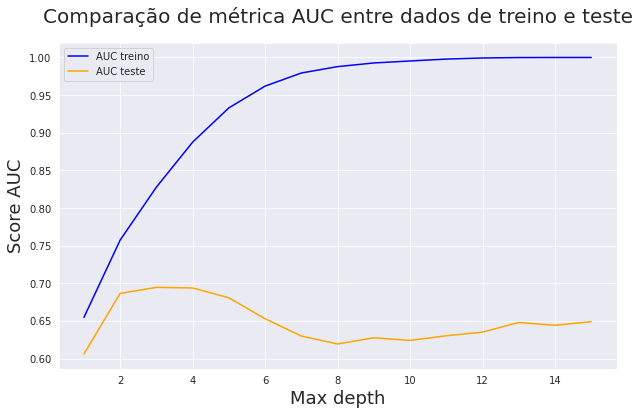

In [67]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data = train_test_ramos,
             x=train_test_ramos.index,
             y='train', label='AUC treino',color='blue')

ax = sns.lineplot(data = train_test_ramos,
             x=train_test_ramos.index,
             y='test',label='AUC teste', color='orange')

ax.set_title('Comparação de métrica AUC entre dados de treino e teste', fontsize=20, pad=20)
ax.set_ylabel('Score AUC', fontsize=18)
ax.set_xlabel('Max depth', fontsize=18)
ax;

### Comentário sobre gráfico de Scores

> Podemos verificar que geralmente as métricas de qualidade começam relativamente próximas até o `max_depth=3`. Depois disso a qualidade do modelo nos dados de teste começa a cair ao passo que o AUC score nos dados de treino aumenta significativamente até, literalmente, acertar todos os resultados nos dados de treino. **Este fenômeno é o OVERFITTING,** quando o modelo se ajusta tanto aos dados de treino que não consegue abstrair informações sobre os dados de teste.

O mesmo valor para o modelo `Logistic Regression`, podemos modificar hiperparâmetros do modelo e analisar a qualidade para cada parâmetro.

In [68]:
iteracoes = np.arange(100,1100,100)
train_test_iteracoes = {}

for iteracao in iteracoes:
    modelo_logistic_reg = LogisticRegression(max_iter = iteracao, solver='newton-cg')
    
    train, test = run_model_with_cross_validation(modelo_logistic_reg, x, y,
                                                  scoring='roc_auc',
                                                  random_state=9817235).loc[['train_score','test_score'], 'mean']
    train_test_iteracoes[iteracao] = (train, test)

train_test_iteracoes = pd.DataFrame(train_test_iteracoes, index=['train','test']).T

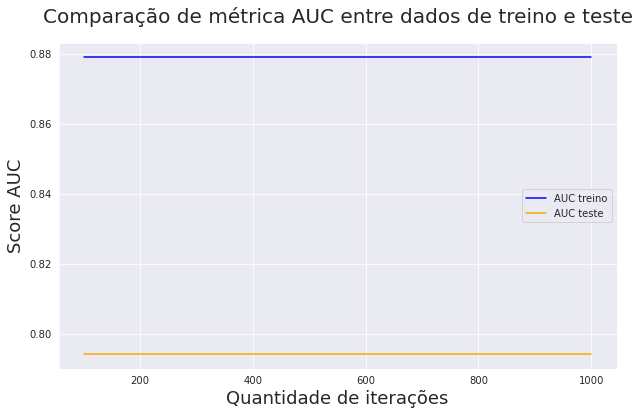

In [69]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data = train_test_iteracoes,
             x=train_test_iteracoes.index,
             y='train', label='AUC treino',color='blue')

ax = sns.lineplot(data = train_test_iteracoes,
             x=train_test_iteracoes.index,
             y='test',label='AUC teste', color='orange')

ax.set_title('Comparação de métrica AUC entre dados de treino e teste', fontsize=20, pad=20)
ax.set_ylabel('Score AUC', fontsize=18)
ax.set_xlabel('Quantidade de iterações', fontsize=18)
ax;

# Propondo correções ao Overfitting

Overfitting é um problema extremamente complexo e pode gerar vários problemas caso o deploy do modelo seja efetuado. Para corrigi-lo devemos estudar cada parâmetro individualmente, ou usar modelos menos sucetíveis a overfitting. 

O Decision Tree é um modelo extremamente sensível ao overfitting e portanto use-o com parcimônia. Por outro, lado temos outra técnica de arvore de decisão chamada `RandomForest`, este modelo mesmo com parâmetros `default` gera bons resultados enquanto não é tão suscetível ao overfitting. 

No Sci Kit Learn a técnica de Random Forest esta dentro do conjunto de `ensembles`. Ensembles é uma tecnica estatistica a respeito de como os dados são gerados. Por exemplo:

> Em uma sala tem um conjunto de 10 alunos. O objetivo é que cada um calcule a média de três medidas da área da mesa em que ele esta e tranfira esta informação para o professor. De que forma esta informação pode ser feita? Bom, primeiro que existem erros inerentes ao processo de medida então é provável que cada aluno encontre um valor de média diferente mesmo que as mesas sejam identicas. Segundo, existem duas formas de transferir a informação, cada aluno pode ir informando um de cada vez ou todos informarem ao mesmo tempo. Neste exemplo é obvio que não faz diferença de que forma o resultado é informado, entretanto existe vários sistemas em que isto faz diferença e que as vezes o resultados são diferentes. Este é o conceito de ensemble, considerar várias cópiar de um mesmo processo, onde são estimados (pelos alunos) o valor de uma variável aleatória. 

Então, o conjunto de modelos ensemble do Sci Kit Learn leva em conta este tipo de teoria a estatistica e da física (mecaninca-estatistica), é possível obter mais informações sobre o módulo na referência.

> Fonte: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

## Random Forest

O modelo da classe ensemble que vamos utilizar é Random Forest, ele é um conjunto de modelos do tipo Decision Tree Classifier.

Um `RandomForest` é um meta-estimador que ajusta vários classificadores de árvore de decisão em várias subamostras do conjunto de dados e usa a média para melhorar a precisão preditiva e o overfitting de controle. O tamanho da subamostra é controlado com o parâmetro `max_samples` se `bootstrap = True`, caso contrário, todo o conjunto de dados é usado para construir cada árvore. Para mais informações: 

> Fonte: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

Para usar o `RandomForest` é preciso implementar a classe:

```python
sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
```

In [70]:
from sklearn.ensemble import RandomForestClassifier

Para comparação vamos utilizar a tecnica anterior. A classe `RandomForestClassifier` tem um hiperparâmetro que pode ser passado ao instanciar um modelo chamado `n_estimators`, com este hiperparâmetro são ditos quantos estimadores do Random Forest irá criar em cada iteração, por padrão se tem 100 estimadores, mas podemos aumentar e verificar qual o impacto disso na qualidade do modelo.

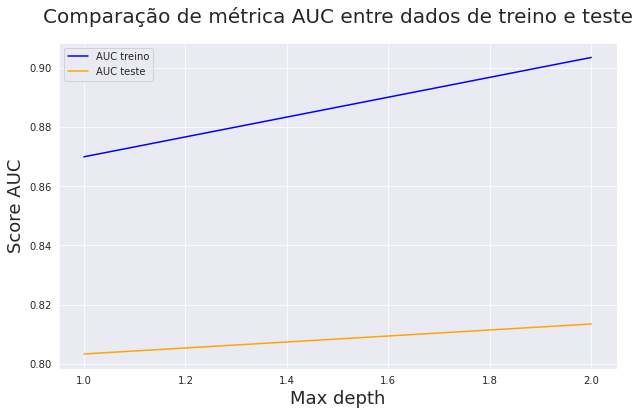

In [71]:
train_test_ramos = {}
for ramos in range(1,3):
    modelo_decision = RandomForestClassifier(max_depth=ramos, n_estimators=120)
    train, test = run_model_with_cross_validation(modelo_decision, x, y,
                                                  scoring='roc_auc',
                                                  random_state=9817235).loc[['train_score','test_score'], 'mean']
    train_test_ramos[ramos] = (train, test)

train_test_ramos = pd.DataFrame(train_test_ramos, index=['train','test']).T

plt.figure(figsize=(10,6))
ax = sns.lineplot(data = train_test_ramos,
             x=train_test_ramos.index,
             y='train', label='AUC treino',color='blue')

ax = sns.lineplot(data = train_test_ramos,
             x=train_test_ramos.index,
             y='test',label='AUC teste', color='orange')

ax.set_title('Comparação de métrica AUC entre dados de treino e teste', fontsize=20, pad=20)
ax.set_ylabel('Score AUC', fontsize=18)
ax.set_xlabel('Max depth', fontsize=18)
ax;

# Features com alta correlação

In [72]:
sirio_libanes_quantitativos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Columns: 230 entries, AGE_ABOVE65 to ICU
dtypes: float64(225), int64(3), int8(1), object(1)
memory usage: 687.5+ KB


Verificamos que dos dados numéricos temos 255 colunas com registros do tipo float64, 3 colunas com tipo int64 e uma coluna do tipo int8 e por fim um dado do tipo object.

In [73]:
sirio_libanes_quantitativos.select_dtypes(exclude='float64')

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ICU
0,1,5,0,0-2,1
1,1,8,1,0-2,1
2,0,0,0,0-2,1
3,0,3,1,0-2,0
4,0,0,0,0-2,0
...,...,...,...,...,...
379,0,3,1,0-2,1
380,1,9,0,0-2,0
381,0,4,0,0-2,1
382,0,3,1,0-2,0


As colunas cujo os dados são do tipo int64, int8 e o object (que é uma string do tipo `0-2`). Podemos regirar esses dados, exceto o ICU que é o nosso classificador. Então vamos tirar as três primeiras variáveis  	`AGE_ABOVE65`,`AGE_PERCENTIL`,`GENDER` e as duas ultimas `WINDOW` e `ICU`:

In [74]:
sirio_libanes_quantitativos.iloc[:,3:-2].corr()

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
DISEASE GROUPING 1,1.000000,0.232833,0.259372,0.018628,0.347914,0.199194,0.464991,0.187721,0.128779,0.013398,...,0.188455,0.042852,0.076589,0.049611,-0.048554,-0.052073,0.162467,0.019039,0.078430,0.049045
DISEASE GROUPING 2,0.232833,1.000000,0.072901,0.107559,0.152228,-0.031235,0.140774,0.122963,0.069931,0.037642,...,0.227727,0.159572,0.219816,0.259062,0.073528,0.028948,0.224602,0.146439,0.221817,0.267425
DISEASE GROUPING 3,0.259372,0.072901,1.000000,0.300146,0.275185,0.268365,0.470774,0.067851,0.140691,-0.009800,...,-0.022354,-0.031549,-0.006847,-0.012592,-0.005903,0.017722,-0.018194,-0.026603,-0.005393,-0.011904
DISEASE GROUPING 4,0.018628,0.107559,0.300146,1.000000,0.127296,0.173474,0.129277,0.102198,0.061509,-0.035429,...,-0.022661,0.005775,0.013765,-0.025052,-0.043890,-0.030982,-0.030845,0.013118,0.014426,-0.024363
DISEASE GROUPING 5,0.347914,0.152228,0.275185,0.127296,1.000000,0.129764,0.437339,0.101896,0.147387,-0.046343,...,0.094562,0.021797,0.040025,0.012239,-0.018934,-0.057854,0.055391,0.006599,0.041944,0.012808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLOODPRESSURE_SISTOLIC_DIFF_REL,-0.052073,0.028948,0.017722,-0.030982,-0.057854,-0.001202,-0.017899,-0.042838,0.036087,0.062668,...,0.315267,0.339359,0.329350,0.432987,0.776732,1.000000,0.349502,0.386949,0.323661,0.429762
HEART_RATE_DIFF_REL,0.162467,0.224602,-0.018194,-0.030845,0.055391,0.004998,0.110824,-0.024410,0.049761,0.030320,...,0.972805,0.558114,0.686505,0.629669,0.321500,0.349502,1.000000,0.555210,0.689311,0.623838
RESPIRATORY_RATE_DIFF_REL,0.019039,0.146439,-0.026603,0.013118,0.006599,-0.048619,-0.010122,-0.006205,0.033245,-0.008773,...,0.523308,0.973030,0.539410,0.517766,0.365927,0.386949,0.555210,1.000000,0.537379,0.513188
TEMPERATURE_DIFF_REL,0.078430,0.221817,-0.005393,0.014426,0.041944,-0.006971,0.085658,-0.019229,-0.006927,0.021769,...,0.645859,0.539246,0.999628,0.706897,0.289099,0.323661,0.689311,0.537379,1.000000,0.701367


Agora temos a correlação apenas entre os dados numéricos float64. Lembrando que a correlação é a covariância normalizada pelo desvio padrão, sendo os máximos $1$ e $-1$ indicando correlação positiva ou negativa e $0$ ausencia de correlação.

A ideia então é remover as variáveis que tenham uma correlação extremamente alta, proxima de 1 (absoluto).

In [75]:
alta_correlacao = 0.95
matriz_corr = sirio_libanes_quantitativos.iloc[:,3:-2].corr().abs()

In [76]:
any(matriz_corr['DISEASE GROUPING 1'] > alta_correlacao)

True

Agora temos um jeito de verificar quais colunas tem um dado com uma correlação maior que $0.95$, acontece que se desejarmos exclui-la iremos excluir todas as colunas, isso porque a matriz de correlação é uma matriz simétrica, ou seja, os elementos acima da diagonal principal são simétricos aos elementos que estão abaixo dela, verifique: 

>  Na coluna `DISEASE GROUPING 1` linha `DISEASE GROUPING 2` o resultado é $0.232833$, mas na coluna `DISEASE GROUPING 2` linha `DISEASE GROUPING 1` o resultado é o mesmo.

é preciso então dar um jeito de excluir apenas uma da variáveis, portanto precisamos recorrer a álgebra linear, ou seja, `Numpy`.

Vamos criar uma matriz com a mesma ordem do dataframe:

In [77]:
matriz_unitaria = np.ones(matriz_corr.shape)
matriz_unitaria

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Podemos converter a matriz num formato booleano:

In [78]:
matriz_booleana = matriz_unitaria.astype('bool')
matriz_booleana

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Além disso precisamos dar um jeito de excluir a diagonal principal ou o triangulo inferior. Para isso existe um método do numpy chamado `np.triu()`:

In [79]:
# se não passar o parâmetro k ele NÃO retira a diagonal principal.
np.triu(matriz_unitaria, k=1)

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
# se não passar o parâmetro k ele NÃO retira a diagonal principal.
matriz_triangular_superior_booleana = np.triu(matriz_unitaria, k=1).astype('bool')
matriz_triangular_superior_booleana

array([[False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

Note que só os elementos acima da diagonal principal tem o valor `True`. Para isso precisamos usar a função `where()` do pandas. Esta função retorna apenas os valores que recebem o valor verdadeiro nos seus elementos.

```python 
DataFrame.where(cond, other=nan, inplace=False, axis=None, level=None, errors='raise', try_cast=False)
```
> Replace values where the condition is False.

In [81]:
matriz_trig_sup_corr = matriz_corr.where(matriz_triangular_superior_booleana)
matriz_trig_sup_corr

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
DISEASE GROUPING 1,NaN,0.232833,0.259372,0.018628,0.347914,0.199194,0.464991,0.187721,0.128779,0.013398,...,0.188455,0.042852,0.076589,0.049611,0.048554,0.052073,0.162467,0.019039,0.078430,0.049045
DISEASE GROUPING 2,NaN,NaN,0.072901,0.107559,0.152228,0.031235,0.140774,0.122963,0.069931,0.037642,...,0.227727,0.159572,0.219816,0.259062,0.073528,0.028948,0.224602,0.146439,0.221817,0.267425
DISEASE GROUPING 3,NaN,NaN,NaN,0.300146,0.275185,0.268365,0.470774,0.067851,0.140691,0.009800,...,0.022354,0.031549,0.006847,0.012592,0.005903,0.017722,0.018194,0.026603,0.005393,0.011904
DISEASE GROUPING 4,NaN,NaN,NaN,NaN,0.127296,0.173474,0.129277,0.102198,0.061509,0.035429,...,0.022661,0.005775,0.013765,0.025052,0.043890,0.030982,0.030845,0.013118,0.014426,0.024363
DISEASE GROUPING 5,NaN,NaN,NaN,NaN,NaN,0.129764,0.437339,0.101896,0.147387,0.046343,...,0.094562,0.021797,0.040025,0.012239,0.018934,0.057854,0.055391,0.006599,0.041944,0.012808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLOODPRESSURE_SISTOLIC_DIFF_REL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.349502,0.386949,0.323661,0.429762
HEART_RATE_DIFF_REL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555210,0.689311,0.623838
RESPIRATORY_RATE_DIFF_REL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537379,0.513188
TEMPERATURE_DIFF_REL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.701367


In [82]:
excluir_elemento = [coluna for coluna in matriz_trig_sup_corr.columns if any(matriz_trig_sup_corr[coluna] > alta_correlacao)]
excluir_elemento

['ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEAN',
 'GLUCOSE_MIN',
 'GLUCOSE_MAX',
 'HEMATOCRITE_MEAN',
 'HEMATOCRITE_MIN',
 'HEMATOCRITE_MAX',
 'HEMOGLOBIN_MEDIAN',
 'HEMOGLOBIN_MEAN',
 'HEMOGLOBIN_MIN',
 'HEMOGLOBIN_MAX',
 'INR_MEAN',
 'INR_MIN',
 'INR_MAX',
 'LACTATE_MEAN',
 'LACTATE_MIN',
 'LACTATE_MAX',
 'LEUKOCYTES_MEAN',
 'LEUKOCYTES_MIN',
 'LEUKOCYTES_MAX',
 'LINFOCITOS_MEAN',
 'LINFOCITOS_MIN',
 'LINFOCITOS_MAX',
 'NEUTROPHILES_MEDIAN',
 'NEUTROPHILES_MEA

> Note que nesta lista estão apenas os dados altamente corralacionados (acima de 0.95) 

In [83]:
def remove_variaveis_altamente_correlacionadas(dados, valor_corte):
    matriz_corr = dados.corr().abs()
    matriz_triangular_superior_booleana = np.triu(np.ones(matriz_corr.shape), k=1).astype('bool')
    matriz_trig_sup_corr = matriz_corr.where(matriz_triangular_superior_booleana)
    excluir_elemento = [coluna for coluna in matriz_trig_sup_corr.columns if any(matriz_trig_sup_corr[coluna] > valor_corte)]
    
    return dados.drop(excluir_elemento, axis='columns')

In [86]:
sirio_libanes_quantitativos_sem_corr= remove_variaveis_altamente_correlacionadas(sirio_libanes_quantitativos, 0.95)

## Re treinando árvore com menos variáveis:

In [87]:
y = sirio_libanes_quantitativos_sem_corr['ICU']
x = sirio_libanes_quantitativos_sem_corr.drop(['ICU','WINDOW'], axis=1)

In [88]:
run_model_with_cross_validation(modelo_decision, x, y, scoring='roc_auc', random_state=2847104726)

,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
fit_time,50.0,0.192260,0.010832,0.181304,0.185391,0.189206,0.194779,0.238657,"(0.1705963, 0.2139233)"
score_time,50.0,0.017863,0.000867,0.017138,0.017314,0.017561,0.017997,0.021924,"(0.0161282, 0.019597)"
test_score,50.0,0.829808,0.044519,0.726046,0.804656,0.833160,0.858300,0.952183,"(0.740769, 0.9188462)"
train_score,50.0,0.907220,0.006982,0.893743,0.901653,0.907252,0.911615,0.926940,"(0.8932553, 0.9211844)"


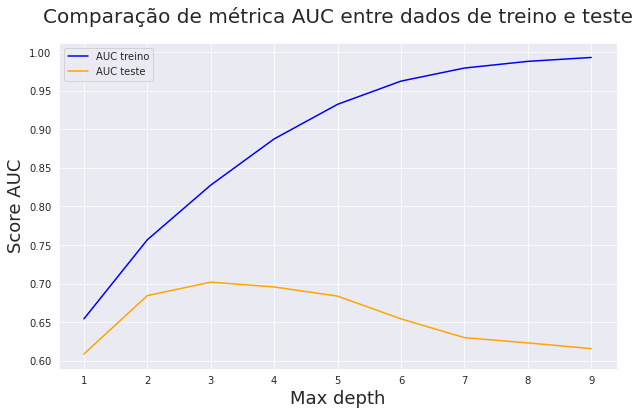

In [91]:
train_test_ramos = {}
for ramos in range(1,10):
    modelo_decision = DecisionTreeClassifier(max_depth=ramos)
    train, test = run_model_with_cross_validation(modelo_decision, x, y, scoring='roc_auc', random_state=2847104726).loc[['train_score','test_score'], 'mean']
    train_test_ramos[ramos] = (train, test)

train_test_ramos = pd.DataFrame(train_test_ramos, index=['train','test']).T

plt.figure(figsize=(10,6))
ax = sns.lineplot(data = train_test_ramos,
             x=train_test_ramos.index,
             y='train', label='AUC treino',color='blue')

ax = sns.lineplot(data = train_test_ramos,
             x=train_test_ramos.index,
             y='test',label='AUC teste', color='orange')

ax.set_title('Comparação de métrica AUC entre dados de treino e teste', fontsize=20, pad=20)
ax.set_ylabel('Score AUC', fontsize=18)
ax.set_xlabel('Max depth', fontsize=18)
ax;

In [92]:
run_model_with_cross_validation(modelo_logistic_reg, x, y, scoring='roc_auc', random_state=2847104726)

,count,mean,std,min,25%,50%,75%,max,conf_int_0.95
fit_time,50.0,0.033223,0.008150,0.025303,0.027346,0.030910,0.033822,0.055030,"(0.0169223, 0.0495242)"
score_time,50.0,0.005339,0.001433,0.004376,0.004467,0.004565,0.006010,0.008812,"(0.0024724, 0.0082054)"
test_score,50.0,0.800263,0.041952,0.711876,0.770918,0.801373,0.822409,0.900810,"(0.7163598, 0.8841669)"
train_score,50.0,0.865015,0.008859,0.845814,0.858677,0.863602,0.872209,0.884785,"(0.8472964, 0.8827338)"


In [96]:
run_dummy_logistic_DecisionTree(x,y, epochs=30,random_state=2847104726)

,count,mean,std,min,25%,50%,75%,max,min_conf_int,max_conf_int
Dummy,30.0,0.500000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Logistic,30.0,0.791721,0.039249,0.728181,0.760530,0.790056,0.815241,0.872340,0.713223,0.870219
DecisionTree,30.0,0.635577,0.041412,0.572948,0.604103,0.625706,0.656644,0.729917,0.552753,0.718401


# Pipelines 

Ao encontrar o melhor modelo, seja de forma manual ou com alguma tecnica de otimização de parâmtetros como [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), o modelo vai ficando cada vez mais complexo de se executar, pois existem várias etapas. Por exemplo, normalizar dados, selecionar características, validação cruzada, enfim, vários processos.

Pensando em resolver essa complexidade e evitar erros nesses processos, existe um recurso do Sklearn chamado [**Pipelines**](https://scikit-learn.org/stable/modules/compose.html#pipelines-and-composite-estimators). Os pipelines são sequencias lineares de necessárias para que um modelo seja utilizado mais facilmente. As etapas de um pipeline são:

> Dados -> Processamento de dados -> seleção das features -> Normalização -> Classificação

As vantagens dessa separação é que o código fica muito mais organizado e legível e por consequência facilita a manutenção, além disso como você terá "*encapsulamento*" das etapas dificulta o vazamento de dados brutos e isso garante a segurança da informação. 

O Scikit-learn permite construir um pipeline através da classe `Pipeline` e para utilizar basta definir a sequencia utilizando uma lista que é composta de tuplas e por sua vez recebe o nome da classe;

In [97]:
from sklearn.pipeline import Pipeline

Feita a importação a estrutura é da seguinte maneira: 

```python
pipe = Pipeline([
    ('nome_etapa1', SelecKBest()),
    ('nome_etapa2', Normalized()),
    ('modelo', LogisticRegression())
])
```

com o pipeline criado, ele será utilizado no lugar do modelo, por exemplo no lugar do cross_validate ou do GridSearchCV. Vamos implementar em um pipeline uma função já criada:

In [101]:
def remove_corr_variaveis(dados, valor_corte):
    """
    Remove as variáveis com uma correlação acima do valor de corte.
    
    :param dados: DataFrame
    :param valor_corte: float
    
    return: DataFrame
    """
    
    matriz_corr = dados.corr().abs()
    matriz_triangular_superior_booleana = np.triu(np.ones(matriz_corr.shape), k=1).astype('bool')
    matriz_trig_sup_corr = matriz_corr.where(matriz_triangular_superior_booleana)
    excluir_elemento = [coluna for coluna in matriz_trig_sup_corr.columns if any(matriz_trig_sup_corr[coluna] > valor_corte)]
    
    return dados.drop(excluir_elemento, axis='columns')

A ideia é que quando o `cross_validation` separar os dados de treino e teste, a função `remove_corr_variaveis()` seja executada em cima dos dados de treino, identifique as variáveis com alta correlação e as remova tanto dos dados de treino quanto dos dados de teste.

Para isso precisamos criar uma classe, escolhi o nome `RemoveCorrVar` e nela vamos construir esta estratéria. Para o Pipeline aceitar uma classe que criamos precisamos colocar entre parênteses `(BaseEstimatior, TransformerMixin)` que funcionam como interfaces obrigando a nossa classe a implementar alguns métodos que o pipeline requisita.

Logo na construção do objeto vamos exigir que seja informado o `valor_corte`, que é o valor máximo de correlação entre as variáveis.

A parte de encontrar as colunas com alta correlação vai ficar dentro do `fit` que por padrão vai receber as festures (`X`) e os classificadores (`Y`).

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin

class RemoveCorrVar(BaseEstimator, TransformerMixin):
    def __init__(self, valor_corte = 0.95):
        self.valor_corte = valor_corte
        
    def fit(self, X, y = None):
        matriz_corr = X.iloc[:,4:].corr().abs()
        matriz_trig_sup = matriz_corr.where(np.triu(np.ones(matriz_corr.shape),
                                                   k=1).astype(np.bool))
        self.excluir = [coluna for coluna in matriz_trig_sup.columns if any(matriz_trig_sup[coluna] > self.valor_corte)]
        return self
    def transform(self, X, y=None):
        X = X.drop(self.excluir, axis = 'columns')
        return X

Agora, finalmente vamos utilizar o pipeline no lugar do modelo dentro da função:

In [106]:
def roda_modelo_cv_pipeline(modelo, dados, n_splits, n_repeats, random_state = None):
    
    seed = np.random.seed(random_state)
    
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados['ICU']
    x = dados[x_columns].drop(['ICU','WINDOW'], axis='columns')
    
    pipeline = Pipeline([
        ('cat_selector',RemoveCorrVar()),
        ('Modelo', modelo)
    ])
    
    tecnica_cv_RSKF = RepeatedStratifiedKFold(n_splits = n_splits,
                                 n_repeats = n_repeats)
    
    resultados = cross_validate(pipeline, x, y, cv = tecnica_cv_RSKF,
                                scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])
    
    auc_std = np.std(resultados['test_score'])
    
    print(f'AUC {auc_medio} - {auc_medio_treino}')
    print(f'conf int [{auc_medio - 2 * auc_std}, {auc_medio + 2 * auc_std}]')
    
    return auc_medio, auc_medio_treino

In [107]:
roda_modelo_cv_pipeline(modelo_logistic_reg,
                       sirio_libanes_quantitativos,
                       n_splits=5,
                       n_repeats=10,
                       random_state=1928375)

AUC 0.799661888609257 - 0.8647591908643234
conf int [0.7066247428758574, 0.8926990343426566]


(0.799661888609257, 0.8647591908643234)

Note que o código ficou extremamente enchuto e por isso a manutenção é muito mais fácil.

# Salvando um Pipeline/Modelo

Lembrando que depois de todas as etapas de treino e teste e quando um modelo atingir um nível de performace razoável para o que se propõem a fazer, antes de salvar precisamos rodar o modelo em todos os dados disponíveis.

Existem várias formas de salvar um modelo, por exemplo usando o [pickle](https://docs.python.org/3/library/pickle.html) (que faz uma serealização do objeto), aqui vou usar a biblioteca [joblib](https://joblib.readthedocs.io/en/latest/) que já vem no anaconda. Vamos salvar um modelo bem simples, por exemplo o *LinearRegression*.

In [109]:
from sklearn.linear_model import LinearRegression

modelo_linear_reg = LinearRegression()
modelo_linear_reg.fit(x,y)

from joblib import dump, load

dump(modelo_linear_reg, 'LinearRegression_SirioLibanes.joblib')

['LinearRegression_SirioLibanes.joblib']

Foi salvo, agora caso queira chamar o modelo ajustado, podemos, chamar usando o método `load`:

In [110]:
modelo_chamado = load('LinearRegression_SirioLibanes.joblib')

In [113]:
modelo_chamado.predict(x)

array([ 3.50145127e-01,  9.27328363e-01,  6.72149803e-01,  5.25546606e-01,
        1.30742141e-01,  1.82615748e-01,  2.47202519e-01,  1.72613766e-01,
        7.20913063e-01,  3.08634106e-01,  4.13630062e-01,  6.02557264e-01,
        5.81349707e-02,  5.92735174e-01,  8.16865535e-01,  6.93682788e-01,
        1.75792432e-01,  8.68106748e-01,  5.61471381e-01,  5.38343314e-01,
        1.90142942e-01,  7.47233145e-01,  4.82397156e-01,  3.63109813e-01,
        7.26765261e-01,  7.09982803e-01,  1.02974442e-01,  9.53091557e-01,
        8.63622058e-01,  1.17261437e+00,  4.33455761e-01,  1.07387250e+00,
       -2.21831737e-02,  2.77684277e-01,  2.71259773e-01,  2.37745508e-01,
        7.89961471e-01,  8.54740954e-01,  4.16326407e-01,  1.03842107e+00,
        4.75353613e-01,  1.17636434e+00,  1.49784707e-01,  3.13710638e-01,
        1.05145412e+00,  4.68467372e-01,  8.01734674e-02,  6.24145195e-01,
        9.87103897e-01,  2.41448675e-01,  6.02765229e-01,  2.82725673e-02,
        5.59058836e-01,  